# Urban Traffic Anomaly Detection using Variational Autoencoders (VAE)

In this project, we aim to detect anomalies in urban traffic patterns using a probabilistic machine learning approach based on Variational Autoencoders (VAE). 

We will train the VAE on typical traffic data so that it learns common patterns. Then, we will detect anomalies as deviations from these learned patterns.

The dataset used is the METR-LA dataset, which contains traffic speed readings from sensors in Los Angeles collected every 5 minutes.


## Data Description


**METR-LA Dataset**

- Contains traffic speed data from 207 sensors in Los Angeles.
- Data is recorded every 5 minutes, resulting in 12 records per hour.
- The data is stored in an HDF5 file format (`metr-la.h5`), where rows represent timestamps and columns correspond to different sensors.
- Additionally, a precomputed sensor graph adjacency matrix is provided (`adj_mx.pkl`) which encodes the spatial relations between sensors.

The data shape is approximately (34272, 207), meaning 34,272 time steps and 207 sensors.


## Environment Setup

We will use Python 3.8+ and the following key libraries:

- `h5py`: to read `.h5` dataset files  
- `tables` (PyTables): a dependency needed by `pandas` to handle HDF5 files  
- `numpy` and `pandas`: for data manipulation  
- `matplotlib`: for visualization  
- `torch` (PyTorch): to build and train our VAE model  

### Installing required packages

You can install them via pip:

```bash
pip install numpy pandas matplotlib h5py tables torch


## Data Loading and Preprocessing

Firstly, we load the traffic data from the `.h5` file using `h5py`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

file_path = 'data/metr-la.h5'
df = pd.read_hdf(file_path)
columns_df = df.columns
print(columns_df)
print(df.shape)
print(df.head())
print(df.tail)

Index(['773869', '767541', '767542', '717447', '717446', '717445', '773062',
       '767620', '737529', '717816',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=207)
(34272, 207)
                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00

### Preliminary Investigation

To better understand the nature of the data, we visualize the time series corresponding to five randomly selected sensors on March 2012. These plots provide insight into traffic flow patterns across different locations in Los Angeles.

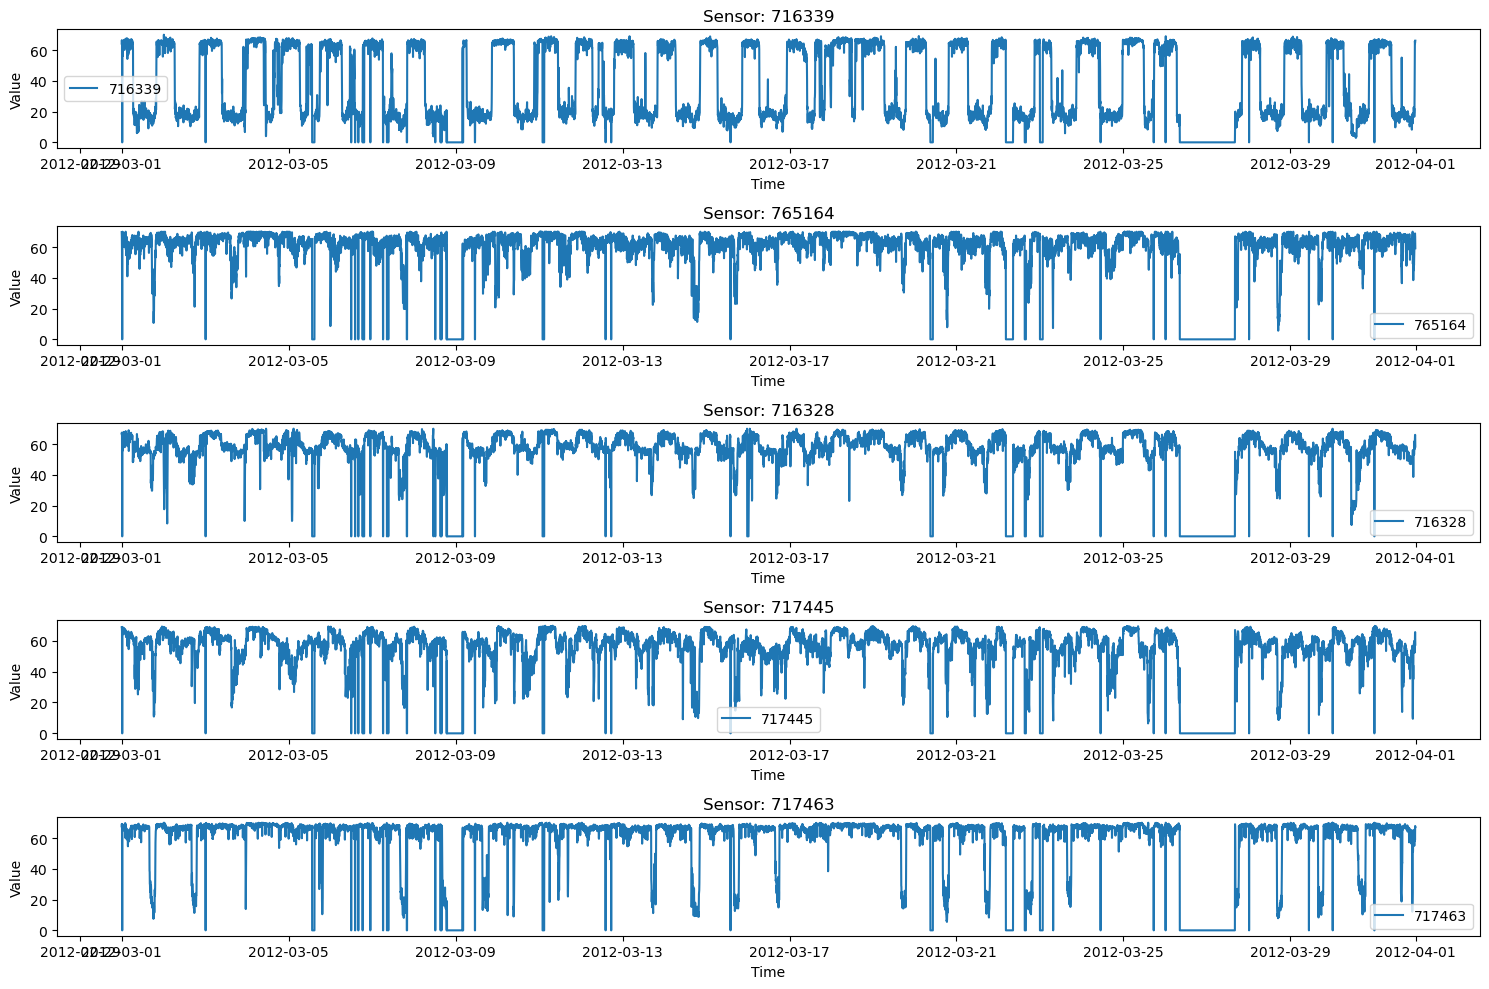

In [36]:

# plotting n plots , one for each time series for randomly picked or specific sensors, just for March 2012
np.random.seed(0)
def plot_random_sensors(df, num_sensors=5, sens=None):
    sensors = np.random.choice(df.columns, num_sensors, replace=False)
    if sens is not None:
        # Filter the sensors based on the provided list
        sensors = [s for s in sens if s in df.columns]
    days = 31
    hourse_per_day = 24
    event_per_hour = 12  # assuming 5 minutes intervals
    event_in_march = days * hourse_per_day * event_per_hour - 1 # Last event is at 31st March 2012, 23:55
    df_subset = df[sensors].iloc[:event_in_march]  # march 2012

    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors):
        plt.subplot(num_sensors, 1, i + 1)
        plt.plot(df_subset.index, df_subset[sensor], label=sensor)
        plt.title(f'Sensor: {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    return sensors


sensors = plot_random_sensors(df, num_sensors=5)

From the plots, we observe that certain time intervals contain prolonged sequences of zero values across all sensors. These zero values likely correspond to missing or invalid sensor readings rather than actual traffic conditions. We search information about why this dataset has this "problem" but in the original paper they did not mentioning it. As it is *highly* unlikely that all traffic in Los Angeles would stop simultaneously across several regions, we decided to threat these as anomalies in the dataset.

This observation leads us to investigate more carefully how to handle these anomalies in the preprocessing stage.

Such rows can bias the model, introduce spurious patterns, and negatively affect training performance.
As a solution, we plan to remove these all-zero rows and fill the resulting gaps using synthetic data generated by a generative model (described in a later section).

Before applying this second-stage correction using generative models, we first need to properly prepare the data. This involves four key steps:

1. **Temporal Feature as Conditional Inputs**: Since traffic patterns are highly dependent on time (e.g., rush hours, weekdays vs. weekends), we extract cyclical time features from the timestamps. These features will later serve as **conditional inputs** for our generative model.

2. **Normalization**: The raw traffic speed values vary significantly across sensors. To ensure efficient training and stable convergence, we normalize the data using `StandardScaler`.

3. **Train/Test Splitting**: We split the time series into training and test sets.

4. **Custom Dataset**: We prepare our data in a format compatible with PyTorch's `DataLoader`

### Time Features as Conditional Inputs

Urban traffic patterns are highly dependent on temporal context. For example:
- Traffic usually peaks during rush hours (e.g., 8 AM and 5 PM).
- Weekends typically have different patterns than weekdays.
- There are seasonal effects tied to months or holidays.

To help our model capture these patterns, we extract cyclical time features from the timestamps:
- Hour of day: mapped to sine and cosine to capture the 24-hour periodicity.
- Day of week: similarly encoded to capture weekly cycles.
- We did not extract the month of year because we only have four months in our dataset

Using both sine and cosine components allows the model to learn the cyclical nature of time (e.g., 23:00 and 0:00 are close in time). {?}




                     hour_sin  hour_cos   dow_sin   dow_cos
2012-03-01 00:00:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:05:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:10:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:15:00       0.0       1.0  0.433884 -0.900969
2012-03-01 00:20:00       0.0       1.0  0.433884 -0.900969


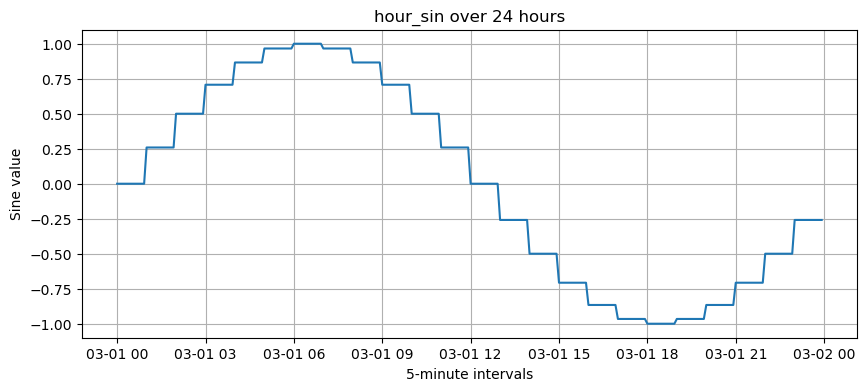

In [4]:
df.index = pd.to_datetime(df.index)
# Create a new DataFrame to store time-based features
df_time = pd.DataFrame(index=df.index)

# Hour of the day (0-23), encoded using sine and cosine to preserve cyclic nature
df_time["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df_time["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

# Day of the week (0=Monday, 6=Sunday), also cyclic
df_time["dow_sin"] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df_time["dow_cos"] = np.cos(2 * np.pi * df.index.dayofweek / 7)

print(df_time.head())

# Plot one day's worth of hour_sin values (12*24 = 288 samples per day)
plt.figure(figsize=(10, 4))
plt.plot(df_time["hour_sin"][:288])  # 1 día si son datos cada 5 minutos
plt.title("hour_sin over 24 hours")
plt.xlabel("5-minute intervals")
plt.ylabel("Sine value")
plt.grid(True)
plt.show()

### Data Normalization and Splitting

Machine learning models, especially neural networks, tend to perform better when the input features are normalized. Here, we use `StandardScaler` from scikit-learn to apply Z-score normalization to the dataset:

- x: the main dataset with traffic speeds from sensors
- c: the time condition variables we computed earlier (e.g., hour_sin, dow_cos, etc.)

The formula applied is: 
$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

Where: 
- 𝜇 is the mean
- 𝜎 is the standard deviation

Each sensor column in x and each time feature in c is scaled independently using this method.

We also split the data into training and test sets to ensure that the scaler is fit only on training data, avoiding any data leakage {the model obtains no info about the future data it will receive, the training output is more realistic}

In [5]:
x = df.values.astype(np.float32)
c = df_time.values.astype(np.float32)

# Split into training and test sets (no shuffling, to preserve temporal order)
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, shuffle=False)
x_train_original = x_train
x_test_original = x_test
# Standardize the input traffic data (x)
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train) # Fit on training data
x_test = scaler_x.transform(x_test) # # Transform test data using the same parameters

# Standardize the conditional time features (c)
scaler_c = StandardScaler()
c_train = scaler_c.fit_transform(c_train)
c_test = scaler_c.transform(c_test)

print("Length of x_train:", len(x_train))
print("Length of x_test:",len(x_test))

Length of x_train: 27417
Length of x_test: 6855


### Custom Dataset: `TrafficDataset`

We define a custom `TrafficDataset` to prepare our data in a format compatible with PyTorch's `DataLoader`.

This class:
- Converts the input features (`x`) and conditions (`c`) into tensors.
- Allows easy indexing and batching of the data.
- Returns tuples `(x, c)` so both the data and its condition can be used during model training.

Using a custom dataset class ensures full control over how data is structured and accessed during training and testing.

In [6]:
class TrafficDataset(Dataset):
    def __init__(self, x, c):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def __len__(self):
        # Return the total number of samples
        return self.x.shape[0]

    def __getitem__(self, idx):
        # Retrieve a single sample (x_t, c_t) given an index
        return self.x[idx], self.c[idx]
    
# Create dataset instances for training and test sets
train_dataset = TrafficDataset(x_train, c_train)
print(len(train_dataset))
test_dataset = TrafficDataset(x_test, c_test)

# Create DataLoaders to iterate through data in batches
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False) #{magari per il training pre missing-values-management si può fare shuffle}
print(len(train_loader))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

27417
215


Training a Conditional Variational Autoencoder (CVAE) with `shuffle=True` can lead to degraded reconstruction quality on structured time series data. Although the CVAE is theoretically permutation-invariant, in practice, shuffled batches introduce heterogeneity that makes learning the conditional latent distribution $q(z|x, c)$ less stable. This instability affects the sampling step $z \sim \mathcal{N}(\mu, \sigma^2)$, producing reconstructions that are less faithful to the input. With `shuffle=False`, temporally coherent batches allow the model to learn more consistent latent representations, especially when the condition vector $c$ carries limited temporal context. Moreover, heterogeneous batches may cause the KL divergence term to dominate the loss, hurting the reconstruction. Therefore, for structured time-series, training without shuffling can yield better reconstructions even under stochastic decoding.

## Theoretical Background

### Variational Autoencoder (VAE)

A **Variational Autoencoder** (VAE) is a type of generative model that learns a continuous, probabilistic latent representation of the data. In our case, the VAE will take a window of traffic sensor readings as input, compress it into a low-dimensional latent vector, and then attempt to reconstruct the original readings. By training the VAE on “normal” traffic patterns, it learns which patterns are likely under the data distribution. At inference time, large reconstruction errors can be flagged as anomalies.

#### Main Components:

##### 1. **Encoder**
The encoder network takes an input (e.g., a time window of traffic data) and maps it to a latent distribution. Instead of directly outputting a single latent vector, the encoder outputs:

- A mean vector $\mu$
- A standard deviation (or log variance) vector $\log(\sigma^2)$

These define a multivariate normal distribution from which we sample the latent variable $z$.

##### 2. **Latent Sampling**
To allow backpropagation through the sampling process, VAEs use the **reparameterization trick**:

$$
z = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling step differentiable.

##### 3. **Decoder**
The decoder takes the sampled latent variable $z$ and tries to reconstruct the original input data. The goal is to learn a meaningful latent space that can generate realistic reconstructions.

#### Loss Function

The VAE loss has two terms that together form the **Evidence Lower Bound (ELBO)**. We optimize (i.e. minimize) the negative ELBO.

1. **Reconstruction Loss** (e.g., Mean Squared Error):

$$
\mathcal{L}_{\text{recon}} = ||x - \hat{x}||^2
$$

This penalizes the model when its reconstruction $\hat{x}$ is far from the original input $x$.

> **Why use MSE as reconstruction loss?**
>
> Theoretically, we want to maximize the log-likelihood of the reconstruction, i.e., $\log p(x|z)$. If we assume that the decoder’s output is Gaussian with fixed variance (i.e., $p(x|z) = \mathcal{N}(\hat{x}, \sigma^2 I)$), then:
>
> $$
> \log p(x|z) = -\frac{1}{2\sigma^2} ||x - \hat{x}||^2 + \text{const}
> $$
>
> So minimizing the squared error (MSE) is equivalent to maximizing the likelihood. That’s why MSE acts as a **proxy** for the negative log-likelihood in practice.


2. **Kullback-Leibler (KL) Divergence**:

$$
\mathcal{L}_{\text{KL}} = D_{\text{KL}}(q(z|x) || p(z))
$$

This measures how much the learned latent distribution $q(z|x)$ (given by the encoder) deviates from the standard normal prior $p(z) = \mathcal{N}(0, I)$.

> **In practice**, the encoder outputs $\mu$ and $\log(\sigma^2)$, and the KL divergence between the approximate posterior and the prior can be computed in closed form:
>
> $$
> \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum \left(1 + \log(\sigma^2) - \mu^2 - \sigma^2\right)
> $$
>
> This encourages the model to keep the latent representations close to a standard normal distribution.


#### Total Loss

The total loss combines both terms:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

where $\beta$ is a hyperparameter (commonly set to 1) that balances reconstruction accuracy and regularization. 

> **Important:** In theory, we want to **maximize** the Evidence Lower Bound (ELBO), which is:
>
> $$
> \text{ELBO}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) || p(z))
> $$
>
> But in practice, optimization libraries **minimize** functions. So minimizing the total loss is equivalent to **maximizing the ELBO**.

---

### Static Conditional Variational Autoencoder (CVAE)

A **Conditional VAE (CVAE)** extends the VAE framework by conditioning both the encoder and decoder on extra context `c`. In our traffic anomaly project, `c` represents **time‐related features** (e.g., `hour_sin`, `hour_cos`, `dow_sin`, etc.). By injecting these features, the model can learn how normal traffic patterns change depending on the time of day, day of week, or month.

> **Why “static” CVAE?**  
> We call it “static” because each training example $(x_t, c_t)$ is treated as independent; we do **not** explicitly model temporal sequences (no RNNs or temporal convolutions). The CVAE simply learns a mapping :
>
>$$
>(x_t, c_t) \;\;\longrightarrow\;\; z \;\;\longrightarrow\;\; (\,\hat{x}_t \mid z, c_t).
>$$
>
> Each pair $(x_t, c_t)$ is processed independently, ignoring direct time‐series dependencies beyond what is encoded in $c_t$.

#### Main Components

- **Input (`x`)**: The data to be reconstructed (e.g., sensor readings).
- **Condition (`c`)**: Extra information that provides context (e.g., timestamp, holiday flag).
- **Encoder**: Maps `x` and `c` into a latent distribution `z ~ q(z|x, c)`.
- **Latent space (`z`)**: A compressed, learned representation of the input data.
- **Decoder**: Uses `z` and `c` to reconstruct the input: `x̂ = p(x|z, c)`.

## CVAE Training Strategy

To address the issue of missing or anomalous data and to prepare the model for detecting anomalies, we adopt a **two-phase training strategy** using the same Conditional Variational Autoencoder (CVAE) architecture. {problem of overfitting?}

### 1. Static CVAE Training on Raw Data (with Zero Rows)

In the first phase, we train the CVAE on individual time steps from the original dataset, **without removing rows with zero values**. Each input sample is a vector representing sensor readings at a single timestamp, and time features (such as hour of day and day of week) are used as conditional inputs.

The goal of this phase is to learn the general distribution {or plural, seen the conditioning?} of traffic sensor readings. Once trained, the model is used to **generate plausible synthetic samples to fill in the rows where all sensor values are zero**, using the corresponding time features for conditioning.

This step allows us to repair the dataset by replacing structurally invalid inputs with statistically consistent samples, improving the overall quality of the data before detecting anomalies.

### 2. CVAE Retraining on Sliding Windows for Temporal Modeling

After filling the missing data, we retrain the same CVAE model using **sliding windows of size 12** {?mmmh}, corresponding to one hour of observations per input sample. This shifts the model’s focus from static snapshots to temporal segments.

This second training phase is essential to enable **sequence-aware generation** and to allow the model to work in combination with a recurrent decoder (LSTM), which requires temporal consistency in the latent space.



In [7]:
# Static Conditional VAE
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        """
        input_dim  : dimensionality of the input vector x (e.g., number of sensors)
        cond_dim   : dimensionality of the condition vector c (e.g., number of time features)
        latent_dim : size of the latent space (z)
        """
        super(CVAE, self).__init__()

        # We will concatenate x and c into a single vector of size (input_dim + cond_dim).
        # Then we pass through two hidden layers: 128 -> 64.
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128), # First dense layer
            nn.ReLU(),                            # Non-linearity
            nn.Linear(128, 64),                   # Second dense layer
            nn.ReLU()
        )

        # After the two layers, we map the 64-dimensional hidden state to:
        #   1) mu (mean) of size latent_dim
        #   2) logvar (log variance) of size latent_dim
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # The decoder takes a latent sample z (size latent_dim) concatenated with the condition c (size cond_dim),
        # forming a vector of size (latent_dim + cond_dim). Then we map:
        #   latent_dim + cond_dim -> 64 -> 128 -> input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) # Output is same size as original x
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        """
        Full forward pass:
        1) Encode (x, c) to obtain mu and logvar.
        2) Sample z using the reparameterization trick.
        3) Decode (z, c) to get reconstructed x.
        Returns:
            x_recon : reconstructed input
            mu      : mean of latent distribution
            logvar  : log-variance of latent distribution
        """
        # 1) Encode input + condition → (mu, logvar)
        mu, logvar = self.encode(x, c)
        # 2) Sample z using reparameterization
        z = self.reparametrize(mu, logvar)
        # 3) Decode the sampled z (with c) → reconstruction
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [8]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss

Train the static vae model:

In [9]:
import torch.optim as optim

device = torch.device("cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
static_vae_model = CVAE(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(static_vae_model.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    static_vae_model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = static_vae_model(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 1.0006 | Recon: 0.9875 | KL: 0.0131
Epoch 2/50 - Loss: 0.9417 | Recon: 0.9395 | KL: 0.0022
Epoch 3/50 - Loss: 0.9235 | Recon: 0.9228 | KL: 0.0008
Epoch 4/50 - Loss: 0.9080 | Recon: 0.9077 | KL: 0.0003
Epoch 5/50 - Loss: 0.8947 | Recon: 0.8945 | KL: 0.0002
Epoch 6/50 - Loss: 0.8826 | Recon: 0.8824 | KL: 0.0002
Epoch 7/50 - Loss: 0.8748 | Recon: 0.8747 | KL: 0.0001
Epoch 8/50 - Loss: 0.8707 | Recon: 0.8706 | KL: 0.0001
Epoch 9/50 - Loss: 0.8650 | Recon: 0.8649 | KL: 0.0001
Epoch 10/50 - Loss: 0.8620 | Recon: 0.8619 | KL: 0.0001
Epoch 11/50 - Loss: 0.8592 | Recon: 0.8591 | KL: 0.0000
Epoch 12/50 - Loss: 0.8570 | Recon: 0.8570 | KL: 0.0000
Epoch 13/50 - Loss: 0.8554 | Recon: 0.8553 | KL: 0.0000
Epoch 14/50 - Loss: 0.8536 | Recon: 0.8535 | KL: 0.0001
Epoch 15/50 - Loss: 0.8521 | Recon: 0.8521 | KL: 0.0001
Epoch 16/50 - Loss: 0.8513 | Recon: 0.8513 | KL: 0.0000
Epoch 17/50 - Loss: 0.8497 | Recon: 0.8497 | KL: 0.0000
Epoch 18/50 - Loss: 0.8482 | Recon: 0.8482 | KL: 0.0000
E

Reconstruct the velocities for the train and the test set using the static VAE model:

In [10]:
reconstructed_train = []
originals_train = []
reconstructed_test = []
originals_test = []

static_vae_model.eval()
with torch.no_grad():
    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = static_vae_model(x_batch, c_batch)
        reconstructed_train.append(x_recon.cpu())
        originals_train.append(x_batch.cpu())

x_train_recon = torch.cat(reconstructed_train, dim=0)  
print(x_train_recon.shape)

static_vae_model.eval()
with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = static_vae_model(x_batch, c_batch)
        reconstructed_test.append(x_recon.cpu())
        originals_test.append(x_batch.cpu())

x_test_recon = torch.cat(reconstructed_test, dim=0)
print(x_test_recon.shape)

torch.Size([27417, 207])
torch.Size([6855, 207])


Cleaning the training dataset from all zeroes rows:

In [11]:
mask_zero_rows = (x_train_original.sum(axis=1) == 0)
print(mask_zero_rows.sum())
train_timestamps = df.index[:len(x_train_original)]

# Converting to a pandas dataframe 
x_train_cleaned_df = pd.DataFrame(data=x_train, index=train_timestamps, columns=columns_df) # with zero values
x_train_recon_df = pd.DataFrame(data=x_train_recon, index=train_timestamps, columns=columns_df) # reconstructed values

x_train_cleaned_df.loc[mask_zero_rows] = x_train_recon_df.loc[mask_zero_rows]
print(mask_zero_rows.shape)
print(x_train.shape)
print(x_train_recon_df.shape)
print(x_train_cleaned_df)

1482
(27417,)
(27417, 207)
(27417, 207)
                       773869    767541    767542    717447    717446  \
2012-03-01 00:00:00  0.429949  0.442313  0.334774  0.751146  1.061140   
2012-03-01 00:05:00  0.354863  0.504537  0.238420  0.813308  0.930317   
2012-03-01 00:10:00  0.413466  0.183202 -0.073736  0.586599  1.040956   
2012-03-01 00:15:00  0.190343  0.106433  0.134731  0.490212  0.766221   
2012-03-01 00:20:00  0.126398  0.082475  0.116834  0.454883  0.747504   
...                       ...       ...       ...       ...       ...   
2012-06-04 04:20:00  0.528842 -0.184569  0.169937  0.364461  0.892939   
2012-06-04 04:25:00  0.393932  0.185060  0.359460  0.345264  1.055907   
2012-06-04 04:30:00  0.353032 -0.284870  0.205771  0.537235  0.960219   
2012-06-04 04:35:00  0.495877 -0.109343  0.406442  0.438507  0.913123   
2012-06-04 04:40:00  0.393932  0.014176  0.384942  0.637791  0.900414   

                       717445    773062    767620    737529    717816  ...  \
2012-

Cleaning the test set from all the all zeroes rows:

In [12]:
# cleaning test set
mask_zero_rows = (x_test_original.sum(axis=1) == 0)
print(mask_zero_rows.sum())
test_index = df.index[:len(x_test_original)]

x_test_cleaned_df = pd.DataFrame(data=x_test, index=test_index, columns=columns_df) # with zero values
x_test_recon_df = pd.DataFrame(data=x_test_recon, index=test_index, columns=columns_df) # reconstructed values

x_test_cleaned_df.loc[mask_zero_rows] = x_test_recon_df.loc[mask_zero_rows]
x_test_cleaned = torch.tensor(x_test_cleaned_df.values, dtype=torch.float32)
print(mask_zero_rows.shape)
print(x_test_cleaned_df)
print(x_test_cleaned.shape)

666
(6855,)
                       773869    767541    767542    717447    717446  \
2012-03-01 00:00:00  0.446431 -0.309945  0.463777  0.520780  1.014043   
2012-03-01 00:05:00  0.424455 -0.167852  0.427943  0.833419  1.040956   
2012-03-01 00:10:00  0.335329 -0.476185  0.034563  0.762115  0.930317   
2012-03-01 00:15:00  0.336550 -0.426963  0.384942  0.603054  0.960219   
2012-03-01 00:20:00  0.359747  0.296505  0.181085  0.557346  1.055907   
...                       ...       ...       ...       ...       ...   
2012-03-24 18:50:00  0.457419  0.326224  0.416795  0.762115 -2.538361   
2012-03-24 18:55:00  0.298091  0.308578  0.298940  0.833419 -2.538361   
2012-03-24 19:00:00  0.545324 -0.089840  0.474129  0.718236 -2.538361   
2012-03-24 19:05:00  0.534336  0.082901  0.270272  0.627736 -2.538361   
2012-03-24 19:10:00  0.462303  0.393091  0.314866  0.732863 -2.538361   

                       717445    773062    767620    737529    717816  ...  \
2012-03-01 00:00:00 -0.460169  0.

Now we can see if we still have those zero-speed peaks on specific dates:

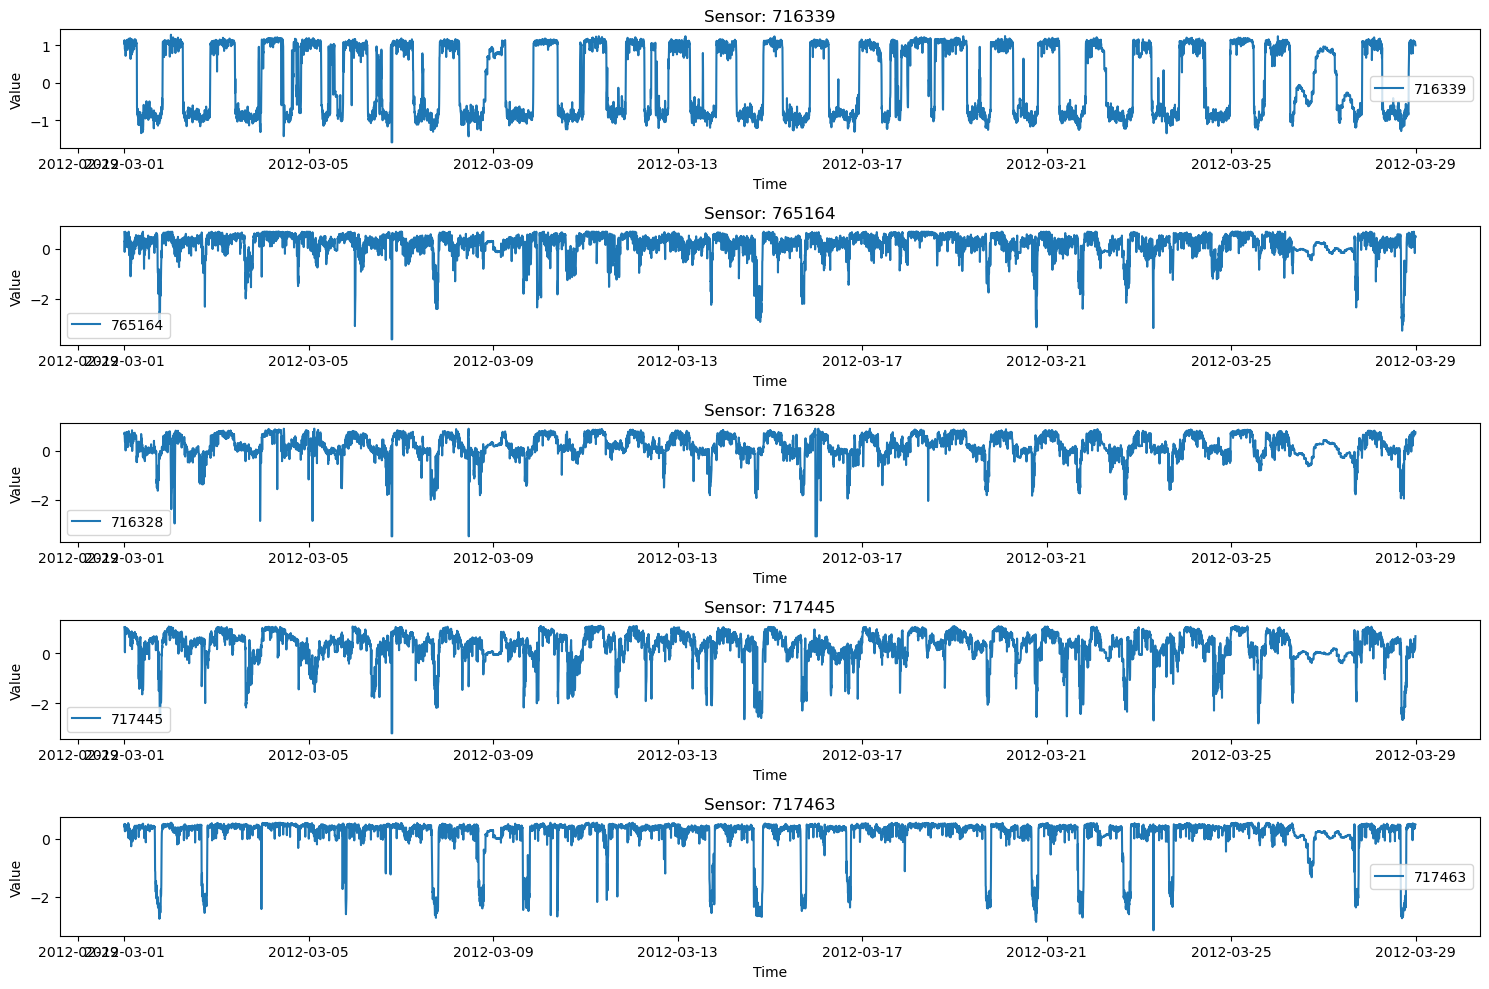

In [13]:
np.random.seed(0)
def plot_random_sensors(x_train_cleaned_df, num_sensors=5):
    sensors = np.random.choice(x_train_cleaned_df.columns, num_sensors, replace=False)
    df_subset = x_train_cleaned_df[sensors].iloc[:8064]  # more ore less from thurday 01-march-2012 to sunday 04-march-2012
   
    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensors):
        plt.subplot(num_sensors, 1, i + 1)
        plt.plot(df_subset.index, df_subset[sensor], label=sensor)
        plt.title(f'Sensor: {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
   
    plt.tight_layout()
    plt.show()
    return sensors

sensors = plot_random_sensors(x_train_cleaned_df, num_sensors=5)

As we can see, #{the anomalies are still clearly visible but???} the dataset is really better

In [14]:
# Create dataset instances for training 
x_train_numpy = x_train_cleaned_df.to_numpy()
train_dataset_cleaned = TrafficDataset(x_train_numpy, c_train)


# Create DataLoaders to iterate through data in batches
train_loader_cleaned = DataLoader(train_dataset_cleaned, batch_size=128, shuffle=False)

### Second model training:

In [15]:
device = torch.device("cpu")

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
second_vae = CVAE(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(second_vae.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    second_vae.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader
    for x_batch, c_batch in train_loader_cleaned:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = second_vae(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 0.4321 | Recon: 0.4245 | KL: 0.0076
Epoch 2/50 - Loss: 0.3651 | Recon: 0.3644 | KL: 0.0007
Epoch 3/50 - Loss: 0.3375 | Recon: 0.3372 | KL: 0.0003
Epoch 4/50 - Loss: 0.3209 | Recon: 0.3207 | KL: 0.0002
Epoch 5/50 - Loss: 0.3124 | Recon: 0.3123 | KL: 0.0001
Epoch 6/50 - Loss: 0.3074 | Recon: 0.3074 | KL: 0.0001
Epoch 7/50 - Loss: 0.3037 | Recon: 0.3036 | KL: 0.0000
Epoch 8/50 - Loss: 0.3010 | Recon: 0.3010 | KL: 0.0000
Epoch 9/50 - Loss: 0.2990 | Recon: 0.2990 | KL: 0.0000
Epoch 10/50 - Loss: 0.2973 | Recon: 0.2973 | KL: 0.0000
Epoch 11/50 - Loss: 0.2959 | Recon: 0.2959 | KL: 0.0000
Epoch 12/50 - Loss: 0.2948 | Recon: 0.2948 | KL: 0.0000
Epoch 13/50 - Loss: 0.2937 | Recon: 0.2937 | KL: 0.0000
Epoch 14/50 - Loss: 0.2930 | Recon: 0.2930 | KL: 0.0000
Epoch 15/50 - Loss: 0.2921 | Recon: 0.2921 | KL: 0.0000
Epoch 16/50 - Loss: 0.2913 | Recon: 0.2913 | KL: 0.0000
Epoch 17/50 - Loss: 0.2907 | Recon: 0.2907 | KL: 0.0000
Epoch 18/50 - Loss: 0.2903 | Recon: 0.2903 | KL: 0.0000
E

Now we want to evaluate the second model, to do that we must reconstruct all the test set:

In [16]:
reconstructed = []
originals = []

second_vae.eval()
with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = static_vae_model(x_batch, c_batch)
        reconstructed.append(x_recon.cpu())
        originals.append(x_batch.cpu())

x_test_full_recon = torch.cat(reconstructed, dim=0)
x_orig_all = torch.cat(originals, dim=0)
print(x_test_full_recon.shape)
print(x_orig_all.shape)


torch.Size([6855, 207])
torch.Size([6855, 207])


### Visualization of Results

#### 1. Reconstruction of Speeds for a Single Sample

This plot compares the **real** sensor speeds against the **reconstructed** speeds generated by the CVAE model for a specific example (sample index 42).

- **Purpose:**  
  To visually assess how well the model reproduces the original traffic speed pattern for that particular sample.

- **What to look for:**  
  - If the two lines closely overlap, the model accurately reconstructs the traffic speeds.  
  - Large deviations indicate the model struggles to capture some sensor readings correctly.


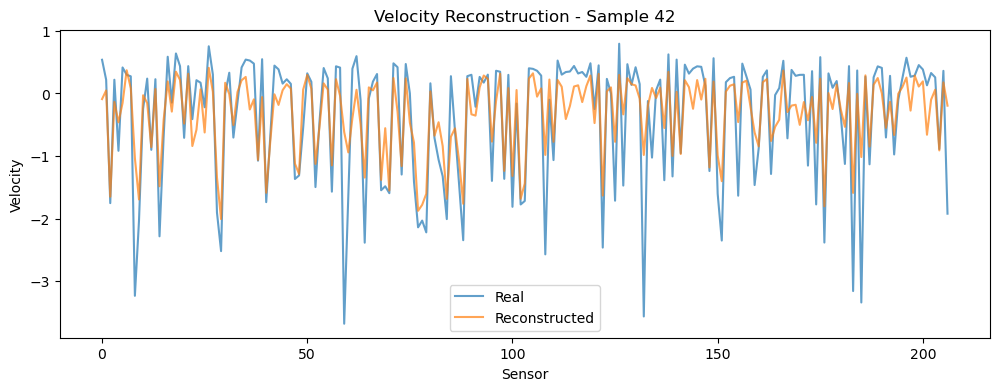

In [17]:
# Plot original vs reconstructed velocities for the selected sample
index_sample = 42  # Select a sample index to visualize
plt.figure(figsize=(12, 4))
plt.plot(x_orig_all[index_sample], label="Real", alpha=0.7)
plt.plot(x_test_full_recon[index_sample], label="Reconstructed", alpha=0.7)
plt.title(f"Velocity Reconstruction - Sample {index_sample}")
plt.xlabel("Sensor")
plt.ylabel("Velocity")
plt.legend()
plt.show()


## Using the cleaned test set to evaluate the model (the flow)

We should evaluate the model on a test set without anomalies (as much as possible...), because we need to pick a model that can reconstruct correctly the "normal" traffic flow and not special situations. #{????}

So we now will calculate the MSE on the test set with the all zero rows reconstructed by the first model

In [18]:
import matplotlib.dates as mdates
# Compute MSE for each sample and sensor (shape: [num_samples, num_sensors])
mse_matrix_recon = (x_test_cleaned - x_test_full_recon) ** 2 
print(mse_matrix_recon.shape)

# Calculate anomaly detection thresholds per sensor
# Option 1: Mean + 3*Std deviation (commented out)
# mean_mse = mse_matrix.mean(dim=0)
# std_mse = mse_matrix.std(dim=0)
# thresholds = mean_mse + 3 * std_mse  # threshold per sensor

# Option 2: Use percentile threshold (e.g., 99.5th percentile)
threshold_recon = torch.quantile(mse_matrix_recon, 0.995, dim=0)

# Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
anomalies_recon = mse_matrix_recon > threshold_recon

# Count how many sensors are anomalous in each sample
anomalous_recon_counts = anomalies_recon.sum(dim=1) 

print("Start of test set:", df.index[-len(x_test)])
print("End of test set:", df.index[-1])
test_timestamps_recon = df.index[-len(x_test):]

torch.Size([6855, 207])
Start of test set: 2012-06-04 04:45:00
End of test set: 2012-06-27 23:55:00


In [19]:
# Get indices of top 10 samples with most anomalies
top_indices_recon = torch.topk(anomalous_recon_counts, 10).indices
top_values_recon = torch.topk(anomalous_recon_counts, 10).values
print(top_values_recon)

print("Top timestamps with the most anomalies:")
for idx in top_indices_recon:
    ts = test_timestamps_recon[idx.item()] # get timestamp for the sample
    count_recon = anomalous_recon_counts[idx].item() # get number of anomalous sensors in that sample
    print(f"Index: {idx.item()} → Date: {ts} → Anomalous Sensors: {count_recon}")


tensor([26, 25, 23, 21, 18, 17, 17, 17, 16, 16])
Top timestamps with the most anomalies:
Index: 4491 → Date: 2012-06-19 19:00:00 → Anomalous Sensors: 26
Index: 4492 → Date: 2012-06-19 19:05:00 → Anomalous Sensors: 25
Index: 172 → Date: 2012-06-04 19:05:00 → Anomalous Sensors: 23
Index: 171 → Date: 2012-06-04 19:00:00 → Anomalous Sensors: 21
Index: 4493 → Date: 2012-06-19 19:10:00 → Anomalous Sensors: 18
Index: 3321 → Date: 2012-06-15 17:30:00 → Anomalous Sensors: 17
Index: 3318 → Date: 2012-06-15 17:15:00 → Anomalous Sensors: 17
Index: 4495 → Date: 2012-06-19 19:20:00 → Anomalous Sensors: 17
Index: 3320 → Date: 2012-06-15 17:25:00 → Anomalous Sensors: 16
Index: 3319 → Date: 2012-06-15 17:20:00 → Anomalous Sensors: 16


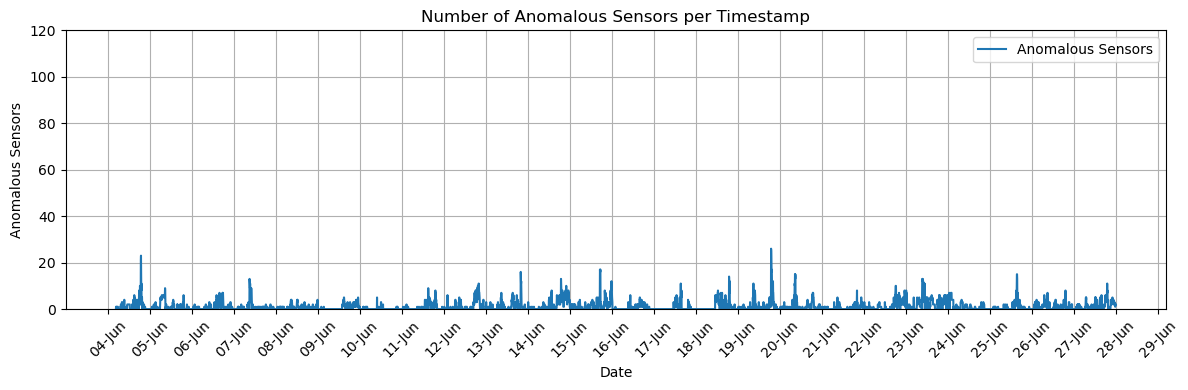

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot number of anomalous sensors over time (timestamps) on test dataset
ax.plot(test_timestamps_recon, anomalous_recon_counts, label='Anomalous Sensors')

# Format X axis to show dates nicely
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))


plt.title("Number of Anomalous Sensors per Timestamp")
plt.xlabel("Date")
plt.ylabel("Anomalous Sensors")
ax.set_ylim(0,120)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

We detect few anomalies, so the MSE is low. #{?????}

A low MSE means good reconstruction capabilities, now we should try to use this model to identifies anomalies

## Understand if the model can be usefull to discover anomalies

### Calculate MSE by timestamp and sensor

To understand if the selected model is usefull to detect speed anomalies, we can now calculate the MSE on the original test set that at least has a lot of rows of all zeroes:

In [21]:
import matplotlib.dates as mdates
# Compute MSE for each sample and sensor (shape: [num_samples, num_sensors])
mse_matrix = (x_orig_all - x_test_full_recon) ** 2 
print(mse_matrix.shape)

# Option 2: Use percentile threshold (e.g., 99.5th percentile)
thresholds = torch.quantile(mse_matrix, 0.995, dim=0)


# Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
anomalies = mse_matrix > thresholds

# Count how many sensors are anomalous in each sample
anomalous_counts = anomalies.sum(dim=1) 

print("Start of test set:", df.index[-len(x_test)])
print("End of test set:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

torch.Size([6855, 207])
Start of test set: 2012-06-04 04:45:00
End of test set: 2012-06-27 23:55:00


In [22]:
import torch

# Get indices of top 10 samples with most anomalies
top_indices = torch.topk(anomalous_counts, 10).indices
top_values = torch.topk(anomalous_counts, 10).values
print(top_values)

print("Top timestamps with the most anomalies:")
for idx in top_indices:
    ts = test_timestamps[idx.item()] # get timestamp for the sample
    count = anomalous_counts[idx].item() # get number of anomalous sensors in that sample
    print(f"Index: {idx.item()} → Date: {ts} → Anomalous Sensors: {count}")


tensor([143, 142, 132, 130, 130, 127, 126, 125, 124, 118])
Top timestamps with the most anomalies:
Index: 3672 → Date: 2012-06-16 22:45:00 → Anomalous Sensors: 143
Index: 3661 → Date: 2012-06-16 21:50:00 → Anomalous Sensors: 142
Index: 3666 → Date: 2012-06-16 22:15:00 → Anomalous Sensors: 132
Index: 3658 → Date: 2012-06-16 21:35:00 → Anomalous Sensors: 130
Index: 3662 → Date: 2012-06-16 21:55:00 → Anomalous Sensors: 130
Index: 3674 → Date: 2012-06-16 22:55:00 → Anomalous Sensors: 127
Index: 3659 → Date: 2012-06-16 21:40:00 → Anomalous Sensors: 126
Index: 3657 → Date: 2012-06-16 21:30:00 → Anomalous Sensors: 125
Index: 3663 → Date: 2012-06-16 22:00:00 → Anomalous Sensors: 124
Index: 3660 → Date: 2012-06-16 21:45:00 → Anomalous Sensors: 118



This plot displays the number of sensors detected as anomalous for each timestamp in the test dataset. The x-axis shows the dates, and the y-axis indicates how many sensors were flagged as anomalies at each point in time.

Red dashed vertical lines mark were we have a lot of all zeros lines in June:

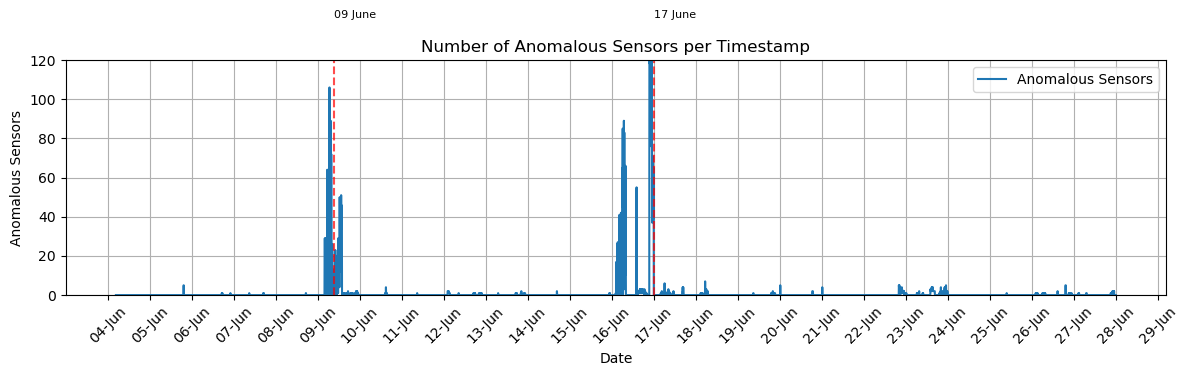

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot number of anomalous sensors over time (timestamps)
ax.plot(test_timestamps, anomalous_counts, label='Anomalous Sensors')

# Format X axis to show dates nicely
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Define some important event dates to mark on the plot
event_dates = {
    '17 June': pd.to_datetime('2012-06-17 00:00:00'),
    '09 June': pd.to_datetime('2012-06-09 09:10:00'),
    #'Unexplained Anomaly': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

plt.title("Number of Anomalous Sensors per Timestamp")
plt.xlabel("Date")
plt.ylabel("Anomalous Sensors")
ax.set_ylim(0,120)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## CVAE + Long Short Term Memory (LSTM) reconstruction in latent space

A **LSTM** (Long Short-Term Memory) is a type of recurrent neural network designed to model sequences and capture long-term dependencies through gated mechanisms that control information flow over time.

The **CVAE + LSTM** model extends the CVAE by introducing an LSTM that operates in the latent space. The CVAE encodes each timestep of a traffic speed sequence into an embedding; the LSTM then models the temporal evolution of these embeddings, predicting the last window_size-1 embeddings using the first window_size -1 ones. Only the **last predicted embedding** is decoded, summarizing the full sequence for reconstruction.

**Trainings** of CVAE and LSTM are kept separate: this improves stability and modularity:
* **Decoupled objectives**: The CVAE learns to encode/reconstruct, while the LSTM models temporal dynamics. Joint training can lead to conflicting gradients and unstable convergence.
* **Better control**: The encoder can be validated independently for embedding quality before feeding sequences to the LSTM.
* **Modularity**: Once trained, components can be reused or replaced independently (e.g., testing different sequence models on the same embeddings).
* **Simpler debugging**: Isolating errors or performance issues is easier when training in stages.

End-to-end training could be explored later for fine-tuning, once both parts perform well individually {????????????????}

> **Why use LSTM inside a CVAE for anomaly detection on traffic speed data?**
> VAE works out for indipendent input data, while time series are characterized by innate sequential dependencies. The inception of a LSTM modul inside the original CVAE allows to account for these dependencies.

### Main Components

* **Encoder (`x`)**: Maps each timestep of input to a latent embedding.
* **Condition (`c`)**: Provides context (e.g., time, day type) to guide encoding and decoding.
* **LSTM**: Models the sequence of embeddings and predicts the next (last) embedding.
* **Decoder**: Reconstructs the final output from the last predicted embedding.

### In the next sections

First, we present the LSTM model definition, the preprocessing of CVAE-embeddings (from train_dataset_cleaned) as LSTM input data,  and the LSTM training over the train data set. Then we move to the CVAE_LSTM model definition and, using the indipendently trained CVAE and LSTM units, we assess its performance over the test dataset {by?????}. Reconstructed time series are plotted. 
Finally, the score function matrix is build, where scores for each sensor are provided over a customizable window_size. According to a percentile threshold, sensors are flagged as anomalous or not over precise-lenght windows. Eventually, timeseries of randomly picked single sensors and histograms about anomalies counts per timestamp are plotted.

### LSTM model training

#### 1. LSTM model definition

In [24]:
# --- LSTM ---
class LSTM_Predictor(nn.Module):
    """
    LSTM-based predictor for sequences of latent embeddings.

    Args:
        embedding_dim (int): Dimensionality of each embedding in the sequence.
        hidden_dim (int): Number of hidden units in the LSTM.
        num_layers (int): Number of stacked LSTM layers.
        dropout_prob (float): Dropout probability (applied if num_layers > 1). For regularization.

    Methods:
        forward(x): Returns predicted embedding sequence.
        compute_loss(predicted_sequence, target_last_embedding): Computes MSE loss on last predicted embedding.
    """
    def __init__(self, embedding_dim, hidden_dim, num_layers=1, dropout_prob=0.1):
        super(LSTM_Predictor, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM processes input sequences of embeddings
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True, # input output LSTM: (batch, seq, feature).
            dropout=dropout_prob if num_layers > 1 else 0
        )
        # Linear layer maps LSTM outputs back to embedding space
        self.fc = nn.Linear(hidden_dim, embedding_dim)

        # MSE loss for comparing predicted and true embeddings
        self.criterion = nn.MSELoss() #draft3 +

    def forward(self, x):
        """
        Forward pass through LSTM and linear layer.

        Args:
            x (Tensor): Input of shape (batch_size, seq_len, embedding_dim)

        Returns:
            predictions (Tensor): Predicted embeddings, shape (batch_size, seq_len, embedding_dim)
        """
        lstm_out, _ = self.lstm(x) # LSTM output: (batch, seq_len, hidden_dim)
        predictions = self.fc(lstm_out) # Map to embedding_dim
        return predictions
    
    # loss : draft3 +
    def compute_loss(self, predicted_sequence, target_last_embedding):
        """
        Compute MSE loss between the last predicted embedding and the true last embedding.

        Args:
            predicted_sequence (Tensor): Output from forward(), shape (batch_size, seq_len, embedding_dim)
            target_last_embedding (Tensor): True last embedding, shape (batch_size, embedding_dim)

        Returns:
            loss (Tensor): Scalar MSE loss
        """
        predicted_last = predicted_sequence[:, -1, :] #Last time step prediction
        loss = self.criterion(predicted_last, target_last_embedding)
        return loss

#### 2. From raw to LSTM input data
...

In [25]:
# Extract all latent embeddings (mu) from the trained VAE for both train and test sets
def get_embeddings(model, data_loader, device="cpu"):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for x_batch, c_batch in data_loader:
            x_batch, c_batch = x_batch.to(device), c_batch.to(device) 
            mu, _ = model.encode(x_batch, c_batch)
            embeddings.append(mu.cpu())
    return torch.cat(embeddings, dim=0) 

# Extract embeddings for train and test sets
embeddings_train = get_embeddings(second_vae, train_loader_cleaned)
embeddings_test = get_embeddings(second_vae, test_loader)
print("Embeddings train:", embeddings_train.shape)
print("Embeddings test:", embeddings_test.shape)

Embeddings train: torch.Size([27417, 16])
Embeddings test: torch.Size([6855, 16])


In [26]:
# Create sliding windows from embeddings for LSTM input/target
def create_sliding_windows(samples, window_size=12):
    """
    Given a tensor of shape [N, D], returns a tensor of shape [num_windows, window_size, D],
    where each window contains 'window_size' consecutive embeddings.
    Windows are created with stride 1 (fully overlapping).
    """
    windows = []
    # Generate all possible windows of length 'window_size'
    for i in range(len(samples) - window_size):
        windows.append(samples[i:i + window_size])
    return torch.stack(windows)

# window_size is default 12 steps = 1 hour of data per window
train_windows = create_sliding_windows(embeddings_train)
test_windows = create_sliding_windows(embeddings_test)

print(train_windows.shape)  # [num_train_windows, 12, latent_dim]
print(test_windows.shape)   # [num_test_windows, 12, latent_dim]

torch.Size([27405, 12, 16])
torch.Size([6843, 12, 16])


In [27]:
# Prepare input and target tensors for LSTM training
# Input: first 11 embeddings in each window (e_1, ..., e_11)
X_train_lstm = train_windows[:, :11, :]
# Target: the last embedding in each window (e_12), used for loss computation
Y_train_lstm_for_loss = train_windows[:, -1, :]

X_test_lstm = test_windows[:, :11, :]
Y_test_lstm_for_loss = test_windows[:, -1, :]

print(f"Shape of X_train_lstm: {X_train_lstm.shape}")
print(f"Shape of Y_train_lstm_for_loss: {Y_train_lstm_for_loss.shape}")

# Create DataLoaders for LSTM training and evaluation
batch_size_lstm = 64  # You can adjust this batch size
train_dataset_lstm = TensorDataset(X_train_lstm, Y_train_lstm_for_loss) #{why we are not using TrafficDataset? better to rename it CustomDataset?}
test_dataset_lstm = TensorDataset(X_test_lstm, Y_test_lstm_for_loss)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)

Shape of X_train_lstm: torch.Size([27405, 11, 16])
Shape of Y_train_lstm_for_loss: torch.Size([27405, 16])


#### 3. LSTM training

In [28]:
# LSTM training
embedding_dim = X_train_lstm.shape[2]

# Tune the following as needed 
hidden_dim_lstm = 64    
num_layers_lstm = 2        

# Initialize LSTM model and optimizer
lstm_model = LSTM_Predictor(embedding_dim, hidden_dim_lstm, num_layers_lstm, dropout_prob=0.2).to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(),  lr=1e-3)

num_epochs_lstm = 50 

# --- Training Loop ---
for epoch in range(num_epochs_lstm):
    lstm_model.train()  
    epoch_loss = 0.0
    for batch_X, batch_Y_target_last in train_loader_lstm:
        batch_X, batch_Y_target_last = batch_X.to(device), batch_Y_target_last.to(device)
        optimizer_lstm.zero_grad()
        predicted_sequence = lstm_model(batch_X) # Forward pass: predict the sequence of embeddings
        loss = lstm_model.compute_loss(predicted_sequence, batch_Y_target_last)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader_lstm)
    print(f"Epoch [{epoch+1}/{num_epochs_lstm}], LSTM Loss: {avg_epoch_loss:.4f}")

Epoch [1/50], LSTM Loss: 0.0001
Epoch [2/50], LSTM Loss: 0.0000
Epoch [3/50], LSTM Loss: 0.0000
Epoch [4/50], LSTM Loss: 0.0000
Epoch [5/50], LSTM Loss: 0.0000
Epoch [6/50], LSTM Loss: 0.0000
Epoch [7/50], LSTM Loss: 0.0000
Epoch [8/50], LSTM Loss: 0.0000
Epoch [9/50], LSTM Loss: 0.0000
Epoch [10/50], LSTM Loss: 0.0000
Epoch [11/50], LSTM Loss: 0.0000
Epoch [12/50], LSTM Loss: 0.0000
Epoch [13/50], LSTM Loss: 0.0000
Epoch [14/50], LSTM Loss: 0.0000
Epoch [15/50], LSTM Loss: 0.0000
Epoch [16/50], LSTM Loss: 0.0000
Epoch [17/50], LSTM Loss: 0.0000
Epoch [18/50], LSTM Loss: 0.0000
Epoch [19/50], LSTM Loss: 0.0000
Epoch [20/50], LSTM Loss: 0.0000
Epoch [21/50], LSTM Loss: 0.0000
Epoch [22/50], LSTM Loss: 0.0000
Epoch [23/50], LSTM Loss: 0.0000
Epoch [24/50], LSTM Loss: 0.0000
Epoch [25/50], LSTM Loss: 0.0000
Epoch [26/50], LSTM Loss: 0.0000
Epoch [27/50], LSTM Loss: 0.0000
Epoch [28/50], LSTM Loss: 0.0000
Epoch [29/50], LSTM Loss: 0.0000
Epoch [30/50], LSTM Loss: 0.0000
Epoch [31/50], LSTM

#### 4. LSTM output embeddings over test set (not really needed)

In [29]:
#from collections import deque

# Evaluate LSTM on test embeddings and collect predictions
lstm_out_embeddings = []

lstm_model.eval()  
with torch.no_grad():
    test_losses = []
    for batch_X, batch_Y_target_last in test_loader_lstm:
        batch_X = batch_X.to(device)
        batch_Y_target_last = batch_Y_target_last.to(device)
        predicted_sequence = lstm_model(batch_X)
        loss = lstm_model.compute_loss(predicted_sequence, batch_Y_target_last)
        test_losses.append(loss.item())
        lstm_out_embeddings.append(predicted_sequence[:, -1, :].cpu())
    
# Compute average loss over the test set
avg_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss LSTM: {avg_test_loss:.4f}")

# Concatenate all predictions into a single tensor
lstm_out_embeddings = torch.cat(lstm_out_embeddings, dim=0) 
print("Shape of LSTM predictions:", lstm_out_embeddings.shape)  # [num_test_windows, embedding_dim]

Test Loss LSTM: 0.0000
Shape of LSTM predictions: torch.Size([6843, 16])


### CVAE_LSTM model, outputs and visualisation
#### 1. CVAE_LSTM model and training over train dataset

During inference, we feed only the mean vector $\mu$ to the decoder (by setting `is_code_input=True`). Doing this bypasses the stochastic sampling $z = \mu + \sigma \odot \epsilon$, making reconstruction fully deterministic. The Gaussian sampling during training regularizes the latent space—encouraging $\mu \sim \mathcal{N}(0,I)$ and preventing overfitting—but is not required at inference time. When the LSTM predicts a latent $\mu$, we want a stable, reproducible reconstruction; adding noise on each $\mu$ would yield blurred or random outputs. Using a VAE instead of a standard autoencoder ensures that even unseen $\mu$ values lie in a well-structured latent space, so the decoder can reliably reconstruct them without stochasticity.


In [30]:
# --- CVAE + LSTM ---
class CVAE_LSTM(nn.Module):
    """
    This model extends the standard CVAE by integrating a temporal LSTM module in the latent space.
    During evaluation, the LSTM predicts the next latent embedding from a sequence of previous embeddings, 
    allowing the decoder to reconstruct x based on temporally-aware latent dynamics.
    """
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        super(CVAE_LSTM, self).__init__()

        # Encoder: concatenates x and c, then passes through two hidden layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128), # First dense layer
            nn.ReLU(),                            # Non-linearity
            nn.Linear(128, 64),                   # Second dense layer
            nn.ReLU()
        )

        # Latent space: outputs mean (mu) and log-variance (logvar) for z
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder: reconstructs x from latent z and condition c
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim) # Output matches original x dimension
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c, lstm_model=None): 
        """
        Forward pass for CVAE_LSTM:
        1) Encode (x, c) to get mu and logvar.
        2) Optionally, in eval mode, use LSTM to predict mu from a sequence of previous mus.
        3) Sample z using the reparameterization trick.
        4) Decode (z, c) to reconstruct x.

        Args:
            x: Input data
            c: Conditional features
            lstm_model: Trained LSTM model for temporal prediction (optional, used in eval)
            mu_queue: Sequence buffer for previous mus (optional, used in eval)
            window_size: Length of the mu sequence for LSTM (default: 12)

        Returns:
            x_recon: Reconstructed input
            mu: Mean of latent distribution
            logvar: Log-variance of latent distribution
        """
        # # preliminari debugging:
        # print(x.shape, c.shape)
        # 1) Encode input and condition to latent parameters
        mu, logvar = self.encode(x, c)

        # 2) In evaluation mode, optionally use LSTM to predict mu from previous mus
        if (not self.training) and (lstm_model is not None):   #only if CVAE is in eval mode and lstm_model and mu_queue are provided
            lstm_model.eval()  # LSTM in eval mode
            with torch.no_grad():
                lstm_out = lstm_model(mu)
            x_recon_seq = self.decode(lstm_out, c)  # Decode using the predicted mu
            x_recon = x_recon_seq[-1, :].unsqueeze(0)  # shape: [1, 207], keep last output from the predicted sequence...NON SICURA DELLE SIZE      
            return x_recon, mu, logvar   # possible to return also mu, logvar 
        
        else: 
            # 2) Sample z using reparameterization
            z = self.reparameterize(mu, logvar)
            
            # 3) Decode the sampled z (with c) → reconstruction
            x_recon = self.decode(z, c)
            return x_recon, mu, logvar

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# training of CVAE_LSTM model over non-overlapping batches of original train data (VOGLIAMO CAMBIARE?)

# Input dimensions from the training data:
input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]

latent_dim = 16
 
model_cvae_lstm = CVAE_LSTM(input_dim, cond_dim, latent_dim).to(device)

# Create an Adam optimizer to update all model parameters
optimizer = optim.Adam(model_cvae_lstm.parameters(), lr=1e-3)

num_epochs = 50

# --- Training Loop ---
for epoch in range(num_epochs):
    model_cvae_lstm.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    # Iterate over the training data in mini-batches provided by train_loader_cleaned
    for x_batch, c_batch in train_loader_cleaned:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        # Zero out all accumulated gradients before computing new ones
        optimizer.zero_grad()

        # Forward pass: compute the reconstruction, plus mu and logvar from the encoder
        x_recon, mu, logvar = model_cvae_lstm(x_batch, c_batch)

        # CVAE loss:
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        
        # Backward pass: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Update model parameters using the computed gradients
        optimizer.step()

        # Accumulate the summed losses across all examples in this batch
        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)
    
    # After finishing all batches in this epoch, compute the average loss per example
    dataset_size = len(train_loader.dataset)
    avg_loss  = total_loss  / dataset_size
    avg_recon = total_recon / dataset_size
    avg_kl    = total_kl    / dataset_size

    # Print out the epoch summary: average total loss, reconstruction loss, and KL loss
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Loss: {avg_loss:.4f} | "
          f"Recon: {avg_recon:.4f} | "
          f"KL: {avg_kl:.4f}")

Epoch 1/50 - Loss: 0.4312 | Recon: 0.4232 | KL: 0.0080
Epoch 2/50 - Loss: 0.3636 | Recon: 0.3627 | KL: 0.0009
Epoch 3/50 - Loss: 0.3359 | Recon: 0.3355 | KL: 0.0003
Epoch 4/50 - Loss: 0.3191 | Recon: 0.3189 | KL: 0.0002
Epoch 5/50 - Loss: 0.3109 | Recon: 0.3108 | KL: 0.0001
Epoch 6/50 - Loss: 0.3066 | Recon: 0.3066 | KL: 0.0001
Epoch 7/50 - Loss: 0.3035 | Recon: 0.3035 | KL: 0.0000
Epoch 8/50 - Loss: 0.3010 | Recon: 0.3010 | KL: 0.0000
Epoch 9/50 - Loss: 0.2991 | Recon: 0.2990 | KL: 0.0000
Epoch 10/50 - Loss: 0.2973 | Recon: 0.2973 | KL: 0.0000
Epoch 11/50 - Loss: 0.2960 | Recon: 0.2959 | KL: 0.0000
Epoch 12/50 - Loss: 0.2947 | Recon: 0.2947 | KL: 0.0000
Epoch 13/50 - Loss: 0.2937 | Recon: 0.2937 | KL: 0.0000
Epoch 14/50 - Loss: 0.2927 | Recon: 0.2927 | KL: 0.0000
Epoch 15/50 - Loss: 0.2921 | Recon: 0.2921 | KL: 0.0000
Epoch 16/50 - Loss: 0.2913 | Recon: 0.2913 | KL: 0.0000
Epoch 17/50 - Loss: 0.2906 | Recon: 0.2906 | KL: 0.0000
Epoch 18/50 - Loss: 0.2901 | Recon: 0.2901 | KL: 0.0000
E

#### 2. CVAE_LSTM evaluation on test set, and plots

Over the original dataset, we rebuild batches as sliding windows of lenght 'window_size'. This is to manage compatibility among CVAE and LSTM inputs/outputs. 

In [32]:
class MyDataset(Dataset):
    def __init__(self, x, c, window):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)
        self.window = window

    def __len__(self):
        return len(self.x) - self.window

    def __getitem__(self, index):
        return self.x[index:index+self.window], self.c[index:index+self.window]


window_size_cvae_lstm = 11  #LSTM input and output sequence length (11 previous embeddings to predict the next one)

input_cvae_lstm = MyDataset(x_test, c_test, window_size_cvae_lstm)
input_cvae_lstm_loader = DataLoader(input_cvae_lstm, batch_size=1, shuffle=False)  # No shuffling to preserve temporal order

In [33]:
# Evaluate CVAE_LSTM model on the test set using LSTM-driven latent dynamics. Batches are overlapping sequences of lenght window_size.

"""
...
"""

vae_lstm_recon = []
vae_lstm_originals = []


model_cvae_lstm.eval()  # Set model to evaluation mode
with torch.no_grad():
    for x_batch, c_batch in input_cvae_lstm_loader:
        x_seq = x_batch.squeeze(0)  # from [batch,window, 207] to [window, 207]
        c_seq = c_batch.squeeze(0)  # from [batch,window, 6] to [window,6]
        x_seq, c_seq = x_seq.to(device), c_seq.to(device)
        # Forward pass: use LSTM to predict temporally-aware latent embedding
        x_recon, mu, logvar = model_cvae_lstm(
            x_seq, c_seq, 
            lstm_model=lstm_model
            )
        vae_lstm_recon.append(x_recon.cpu())
        vae_lstm_originals.append(x_seq[-1,:].unsqueeze(0).cpu())

vae_lstm_recon_all = torch.cat(vae_lstm_recon, dim=0)     # [Nw_test, 207]
print("vae_lstm_recon_all shape", vae_lstm_recon_all.shape)
vae_lstm_originals = torch.cat(vae_lstm_originals, dim=0) # [Nw_test, 207]

vae_lstm_recon_all shape torch.Size([6844, 207])


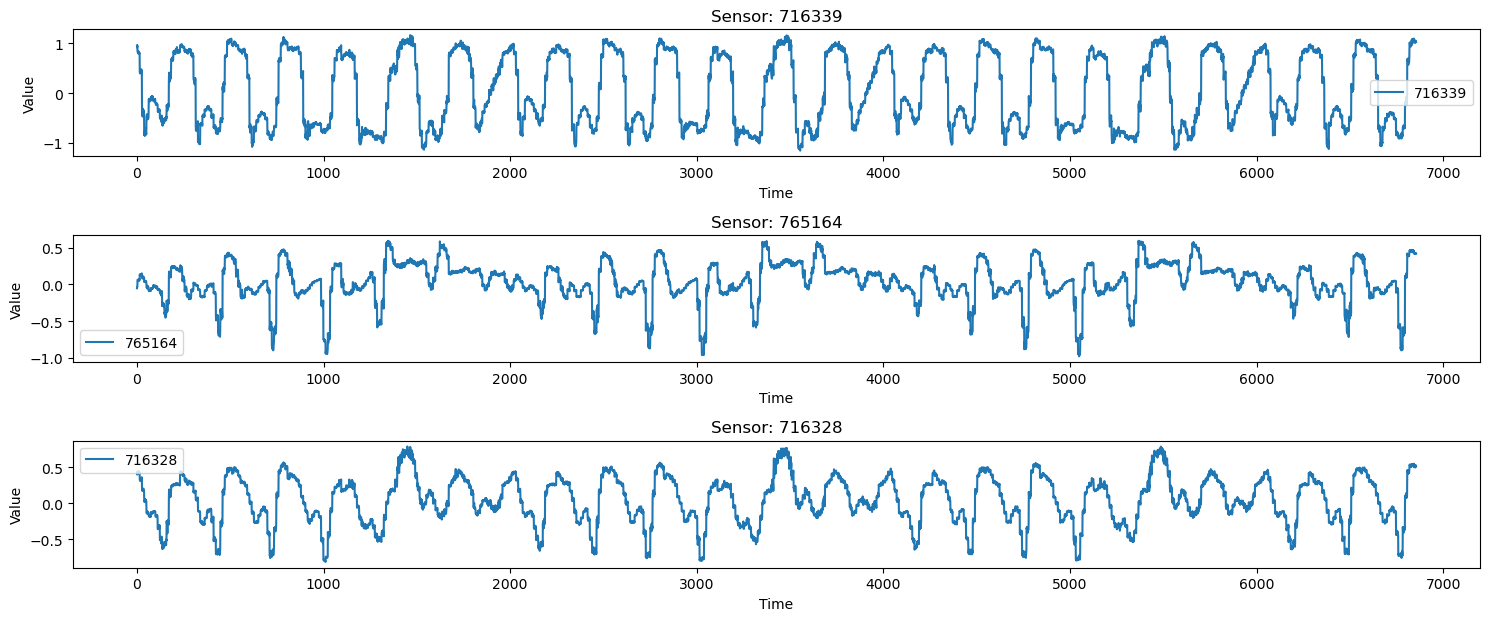

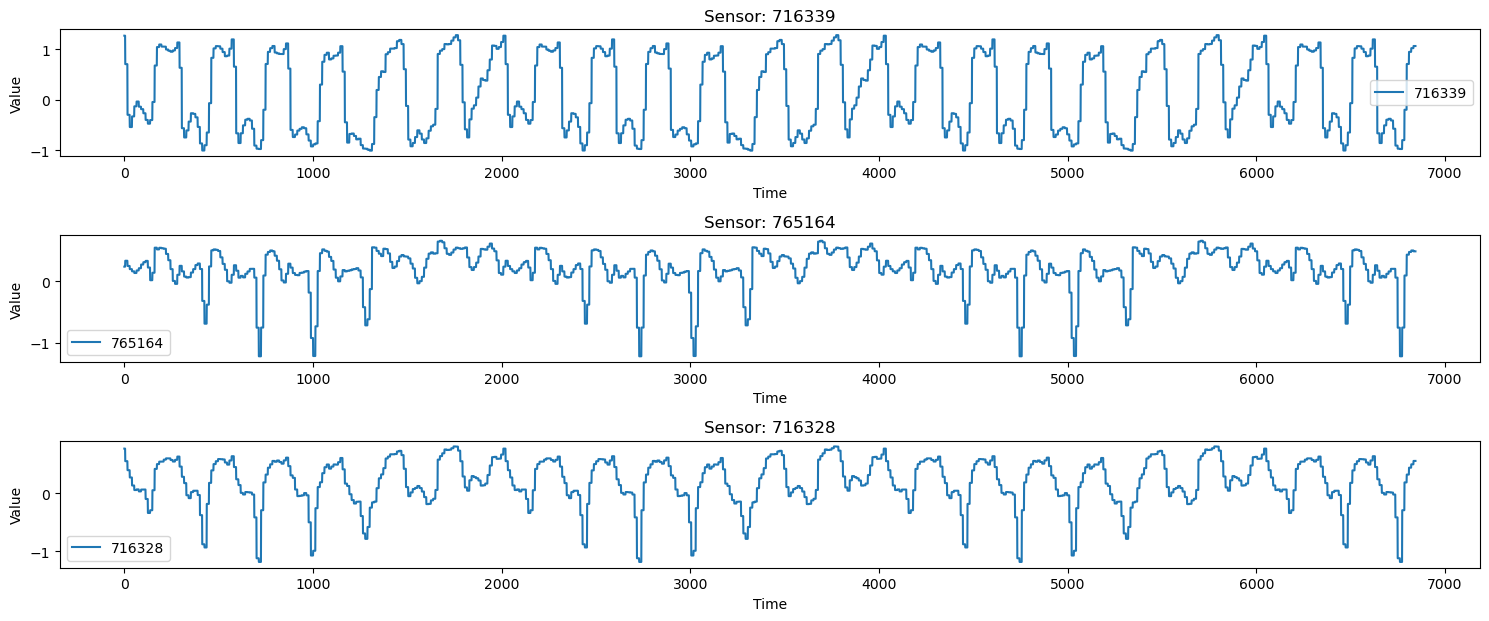

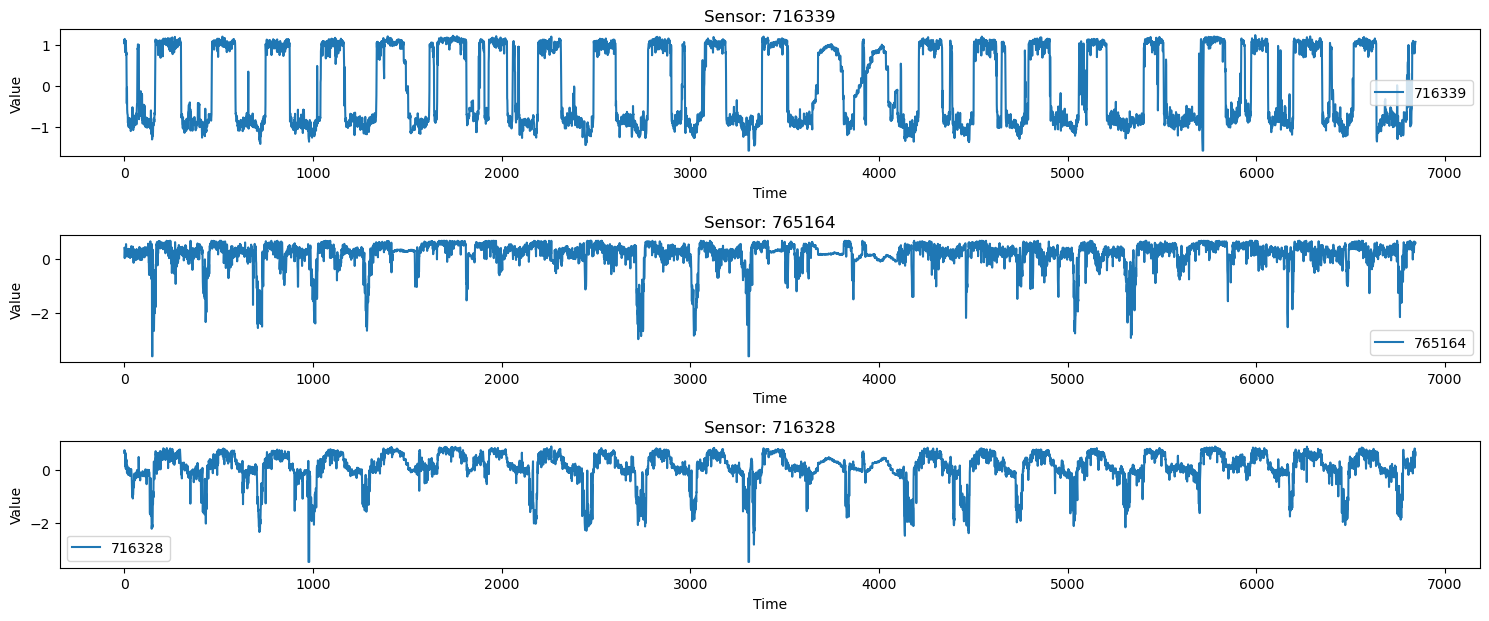

vae_lstm_originals_       773869    767541    767542    717447    717446    717445    773062  \
0   0.369514  0.133052  0.340348  0.623165  1.067868  0.305462  0.675527   
1   0.402478 -0.117701  0.413609  0.586599  1.074596  0.257450  0.660173   
2   0.550818  0.191561  0.435110  0.265733  1.000587  0.280599  0.165588   
3   0.384165  0.103333  0.009081  0.177061  1.061887  0.271167  0.772505   
4   0.473901  0.350371  0.420776  0.446734  1.014043 -0.220963  0.601986   
5   0.550208 -0.074980  0.410424  0.484214  0.960219  0.291745  0.720783   
6   0.534336  0.199919  0.399276  0.372689  1.101508  0.357762  0.652899   
7   0.428117  0.162770  0.378571  0.272132  1.020024  0.387770  0.649667   
8   0.528842  0.208277  0.399276  0.413825  0.879483  0.450358  0.812912   
9   0.528842  0.057826  0.377775  0.430280  0.852571  0.087690  0.631079   
10  0.545324  0.125622  0.283013  0.308698  0.691098  0.271167  0.656132   
11  0.534336  0.183202  0.334774  0.208142  0.758378  0.303748  0.74

In [42]:
# plot of reconstructed time series for 3 sensors against the original ones of the same sensors (test set)
specific_sensors = ["716339", "765164", "716328"]

#CVAE
x_recon_all_ = pd.DataFrame(x_test_full_recon.numpy(), columns=df.columns)
cvaerecon_time_series = plot_random_sensors(x_recon_all_, sens=specific_sensors)

#CVAE_LSTM
vae_lstm_recon_all_ = pd.DataFrame(vae_lstm_recon_all.numpy(), columns=df.columns) 
recon_time_series = plot_random_sensors(vae_lstm_recon_all_, sens=specific_sensors)

#ORIGINAL CLEANED
vae_lstm_originals_ = pd.DataFrame(vae_lstm_originals.numpy(), columns=df.columns) 
orig_time_series = plot_random_sensors(vae_lstm_originals_, sens=specific_sensors)

print("vae_lstm_originals_", vae_lstm_originals_.head(20))
print("vae_lstm_recon_all_", vae_lstm_recon_all_.head(20))


### SCORE FUNCTION and Results Visualization
...

We use the score function to compute the MSE between reconstruction and real data for each sensor and over defined time windows. This allows us to identify anomalous sensors when the error exceeds a percentile threshold, even over prolonged periods. In the future, it would be interesting to explore a composite score that considers both the magnitude of the anomaly and the number of anomalous sensors per window, for a more robust detection.

>$$
\text{Score}_{t \in W,s} = \sum_{t} \left(x^{\text{recon}}_{t,s} - x^{\text{orig}}_{t,s} \right)^2
$$

In [ ]:
# MSE as a score function to spot anomalies, mse per sensor and over window of lenght window_size

import torch.nn.functional as F

class AnomalyDetector:
    """
    A class to detect anomalies in time series data using a score function based on MSE.
    It computes per-sensor MSE between reconstructed and original data, and a rolling mean over a window.
    """
    def __init__(self, x_recon, x_orig, window_size=12, percentile=99.5):
        self.window_size = window_size
        self.percentile = percentile
        self.x_recon = x_recon #pandas DataFrame (comes with and index)
        self.x_orig = x_orig #pandas DataFrame
    
    def score_function(self):
        """
        Compute the per-sensor MSE between reconstructed and original data, and a rolling mean over a window.
        Returns:
            mse_matrix: DataFrame of raw MSE values (samples x sensors)
            mse_windows: DataFrame of rolling mean MSE (windowed)
            thresholds: Array of per-sensor thresholds (percentile over all MSEs)
            thresholds_windows: Array of per-sensor thresholds (percentile over windowed MSEs)
        """
        # Ensure x_recon and x_orig have the same number of samples
        x_recon = self.x_recon
        x_orig = self.x_orig
        dif = x_recon.shape[0] - x_orig.shape[0]
        if dif > 0:
            x_recon = x_recon[:x_orig.shape[0]] 
        elif dif < 0:
            x_orig = x_orig[-x_recon.shape[0]:]
            
        # Compute per-sample, per-sensor MSE
        mse_matrix = (x_recon - x_orig) ** 2  
        mse_matrix = pd.DataFrame(mse_matrix, index=x_orig.index, columns=x_orig.columns)

        # Compute rolling mean MSE over the specified window size 
        mse_windows = mse_matrix.rolling(window=self.window_size, min_periods=self.window_size).mean() 

        # Compute anomaly thresholds as the given percentile for each sensor (over a window)
        #thresholds = np.percentile(mse_matrix.values, percentile, axis=0) 
        thresholds_windows = np.percentile(mse_windows.values, self.percentile, axis=0) 

        return mse_windows , thresholds_windows, mse_matrix #to return mse_matrix and thresholds is redundant
    
    #Detect anomalies: boolean matrix where True means anomaly for that sensor in that sample
    def anomalies_per_timestamp(self):
        """
        Detect anomalies in each sample based on the MSE thresholds.
        Returns a boolean matrix where True indicates an anomaly for that sensor in that sample.
        """
        mse_windows, thresholds_windows = self.score_function()
        anomalies = mse_windows > thresholds_windows 
        print(f"Anomalies detected: {anomalies.sum().sum()}")  # Total number of anomalies detected
        return anomalies.sum(axis=1) 

    #Samples with most anomalies
    def print_top_anomalous_timestamps(self, num_samples=10):
        """
        Print the top samples with the most anomalies.
        """
        anomalies = self.anomalies_per_timestamp()
        # Convert to tensor for torch.topk
        anomalies = torch.tensor(anomalies.values)
        top_indices = torch.topk(anomalies, num_samples).indices
        top_values = torch.topk(anomalies, num_samples).values
        
        print(f"Top {num_samples} samples with most anomalies:")
        for idx in top_indices:
            # Get the timestamp for the sample
            mse_windows, _ = self.score_function()
            ts = mse_windows.index[idx.item()]
            count = anomalies[idx].item()  # Get number of anomalous sensors in that sample
            print(f"Index: {idx.item()} → Date: {ts} → Anomalous Sensors: {count}")

        fig, ax = plt.subplots(figsize=(12, 4))

        # Plot number of anomalous sensors over time (timestamps) on test dataset
        ax.plot(mse_windows.index, anomalies.numpy(), label='Anomalous Sensors')

        # Format X axis to show dates nicely
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

        plt.title("Number of Anomalous Sensors per Timestamp")
        plt.xlabel("Date")
        plt.ylabel("Anomalous Sensors")
        ax.set_ylim(0,120)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

    # time series reconstruction and anomaly detection
    def anomalies_per_series(self, num_sensors=10):
        """
        Trova e visualizza le 10 serie con il massimo picco di MSE su finestra.
        Evidenzia la finestra anomala sul grafico.
        """
        import matplotlib.pyplot as plt

        mse_windows, _ = self.score_function()
        # Trova per ogni sensore il valore massimo di rolling MSE e il relativo indice
        max_mse = mse_windows.max()
        idx_max = mse_windows.idxmax()

        # Prendi i 10 sensori con il massimo valore assoluto di rolling MSE
        top_sensors = max_mse.sort_values(ascending=False).head(num_sensors).index

        for sensor in top_sensors:
            series = self.x_orig[sensor]
            recon = self.x_recon[sensor]
            mse_rolling = mse_windows[sensor]
            # Trova l'indice di inizio della finestra anomala
            idx_peak = idx_max[sensor]
            # Ricava la posizione numerica dell'indice
            if hasattr(series.index, 'get_loc'):
                pos_peak = series.index.get_loc(idx_peak)
            else:
                pos_peak = list(series.index).index(idx_peak)
            # Calcola la finestra
            start = max(0, pos_peak - self.window_size + 1)
            end = pos_peak + 1

            plt.figure(figsize=(14, 5))
            plt.plot(series.index, series, label='Original', alpha=0.7)
            plt.plot(series.index, recon, label='Reconstructed', alpha=0.7)
            plt.title(f"Sensor {sensor} - Max rolling MSE window")
            plt.xlabel("Time")
            plt.ylabel("Value")
            # Evidenzia la finestra anomala
            plt.axvspan(series.index[start], series.index[end-1], color='red', alpha=0.2, label='Anomalous window')
            plt.legend()
            plt.tight_layout()
            plt.show()



# Prepare indexes and columns for DataFrames
df_time_train, df_time_test = train_test_split(df_time, test_size=0.2, shuffle=False)
index = df_time_test.index  # Index for test set
# Index for windowed output .....before was index_lstm_decoded = df_time_test.index[window_size-1:] CHECK
columns = df.columns

# # Calcola la lunghezza corretta per l'indice delle finestre
window_size = 12  # o il valore che hai usato per la rolling window
# valid_index = pd.to_datetime(index[window_size-1:]) # Prendi solo gli ultimi N-window_size+1 timestamp

print("vae_lstm_originals_", vae_lstm_originals_.head(30))

vae_lstm_recon_all_.index = index[window_size-1:]
vae_lstm_originals_.index = index[window_size-1:]
# print("tail of reconstructed data:\n", vae_lstm_recon_all_.tail())
# print("tail of original data:\n", vae_lstm_originals_.tail())


# Initialize the anomaly detector with the reconstructed and original data
detector = AnomalyDetector(vae_lstm_recon_all_, vae_lstm_originals_, window_size=12, percentile=99.5)

boo, _ ,ciao = detector.score_function()
# print("MSE matrix", ciao.head(30))
# print("MSE windows", boo.head(30))





# detector.anomalies_per_timestamp()
# detector.print_top_anomalous_timestamps() #default= 10 samples
# detector.anomalies_per_series() #default= 10 sensors

del AnomalyDetector